# Motivation

- There is a non-negligible number of homonyms in financial named entities such as company names
- E.g., 6.3% of the Korean company names are homonyms
- Assume we simply test if specific patterns like financial named entities are contained within a corpus
- Then we are likely to find a significant number of false positives by homonyms. 

In [1]:
import requests
import tarfile
import os
import math
import pandas as pd
from pandarallel import pandarallel
import dart_fss as dart
from tqdm import tqdm
import matplotlib.pyplot as plt
pandarallel.initialize(progress_bar=True, use_memory_fs=True)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Loading MeCab vocabulary

- We can request an API key `dart_api_key` from `https://opendart.fss.or.kr/uss/umt/EgovMberInsertView.do`

In [2]:
mecab_ko_dic_url = 'https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz'
mecab_ko_dic_directory = './mecab-ko-dic-2.1.1-20180720'
dart_api_key = ''

In [3]:
!curl -LO $mecab_ko_dic_url
!tar zxfv mecab-ko-dic-2.1.1-20180720.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 47.4M  100 47.4M    0     0  8323k      0  0:00:05  0:00:05 --:--:-- 10.6M
mecab-ko-dic-2.1.1-20180720/
mecab-ko-dic-2.1.1-20180720/configure
mecab-ko-dic-2.1.1-20180720/COPYING
mecab-ko-dic-2.1.1-20180720/autogen.sh
mecab-ko-dic-2.1.1-20180720/Place-station.csv
mecab-ko-dic-2.1.1-20180720/NNG.csv
mecab-ko-dic-2.1.1-20180720/README
mecab-ko-dic-2.1.1-20180720/EF.csv
mecab-ko-dic-2.1.1-20180720/MAG.csv
mecab-ko-dic-2.1.1-20180720/Preanalysis.csv
mecab-ko-dic-2.1.1-20180720/NNB.csv
mecab-ko-dic-2.1.1-20180720/Person-actor.csv
mecab-ko-dic-2.1.1-20180720/VV.csv
mecab-ko-dic-2.1.1-20180720/Makefile.in
mecab-ko-dic-2.1.1-20180720/matrix.def
mecab-ko-dic-2.1.1-20180720/EC.csv
mecab-ko-dic-2.1.1-20180720/NNBC.csv
mecab-ko-dic-2.1.1-20180720/clean
mecab-ko-

In [4]:
def load_mecab_ko_dic_vocabulary(source_directory):
    result = list()
    columns = [
        '표층형', 'left-ID', 'right-ID', '비용', 
        '품사', '의미 부류', '종성 유무', '읽기', 
        '타입', '첫번째 품사', '마지막 품사', '표현'
    ]

    entries = os.listdir(source_directory)
    for idx, entry in enumerate(entries):
        # 'Wikipedia.csv' includes some of company names
        if entry in ['Wikipedia.csv']: continue
        entry_path = os.path.join(source_directory, entry)
        if os.path.isdir(entry_path): continue
        filename, extension = os.path.splitext(entry)
        if not extension == '.csv': continue
        
        dataframe = pd.read_csv(
            entry_path, 
            header=None, 
            names=columns,
        )
        dataframe.insert(dataframe.shape[1], '소스', entry)
        result.append(dataframe)
    
    result = pd.concat(result, axis=0, ignore_index=True)
    return result

In [5]:
vocabulary = load_mecab_ko_dic_vocabulary(mecab_ko_dic_directory)

In [6]:
vocabulary

,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
0,가가호호,735,2649,3337,MAG,성분부사|양태부사,F,가가호호,*,*,*,*,MAG.csv
1,가각히,726,2633,4017,MAG,*,F,가각히,*,*,*,*,MAG.csv
2,가강히,726,2633,4017,MAG,*,F,가강히,*,*,*,*,MAG.csv
3,가공스레,726,2633,4017,MAG,*,F,가공스레,*,*,*,*,MAG.csv
4,가관스레,726,2633,4017,MAG,*,F,가관스레,*,*,*,*,MAG.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779516,쿠노,2,3,2124,EC,*,F,쿠노,*,*,*,*,EC.csv
779517,티,2,3,3500,EC,*,F,티,*,*,*,*,EC.csv
779518,하고,2,3,3327,EC,*,F,하고,*,*,*,*,EC.csv
779519,히,2,3,5168,EC,*,F,히,*,*,*,*,EC.csv


## Loading Korean company names

In [7]:
def load_korean_companies(dart_api_key):
    dart.set_api_key(api_key=dart_api_key)
    result = dart.get_corp_list()
    return result

In [8]:
korean_companies = load_korean_companies(dart_api_key)

Output()

Output()

Output()

In [9]:
korean_companies

Number of companies: 96917

In [10]:
korean_companies[-1]

Label,Data
corp_code,01143737
corp_name,에이치엠지글로벌
stock_code,None
modify_date,20221114


In [11]:
korean_company_names = pd.Series([company.corp_name for company in tqdm(korean_companies)])

100%|██████████| 96917/96917 [00:00<00:00, 431849.81it/s]


In [12]:
korean_company_names[:10]

0                   다코
1                 일산약품
2                굿앤엘에스
3                 한라판지
4    크레디피아제이십오차유동화전문회사
5               연방건설산업
6       브룩스피알아이오토메이션잉크
7              매경아이비아이
8                 캐드뱅크
9     엠와이오피삼차유동화전문유한회사
dtype: object

## Finding homonym(s)

In [13]:
homonym_indices = vocabulary['표층형'].isin(korean_company_names)

In [14]:
homonym_indices

0         False
1         False
2         False
3         False
4         False
          ...  
779516    False
779517    False
779518    False
779519    False
779520    False
Name: 표층형, Length: 779521, dtype: bool

In [15]:
homonyms = vocabulary[homonym_indices]

In [16]:
homonyms

,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
300,강동,726,2634,4054,MAG,*,T,강동,*,*,*,*,MAG.csv
728,고리,726,2633,4265,MAG,*,F,고리,*,*,*,*,MAG.csv
1042,구구,726,2633,4340,MAG,*,F,구구,*,*,*,*,MAG.csv
1539,기연,726,2634,4092,MAG,*,T,기연,*,*,*,*,MAG.csv
1581,길,726,2634,6255,MAG,*,T,길,*,*,*,*,MAG.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779500,지비,2,3,2124,EC,*,F,지비,*,*,*,*,EC.csv
779503,지우,2,3,2277,EC,*,F,지우,*,*,*,*,EC.csv
779504,지유,2,3,2156,EC,*,F,지유,*,*,*,*,EC.csv
779505,지이,2,3,2829,EC,*,F,지이,*,*,*,*,EC.csv


## Showing a tendency of the homonyms

### Proportion

<AxesSubplot:ylabel='Is homonym?'>

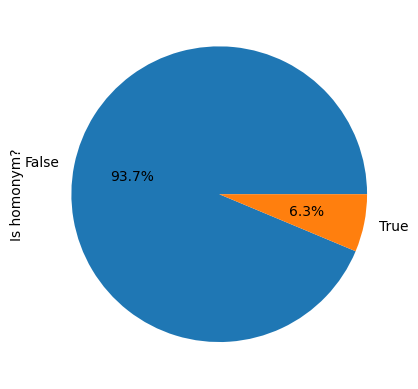

In [17]:
korean_company_names.isin(homonyms['표층형']).value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%', ylabel='Is homonym?')

### Distribution of the length (of the vocabulary)

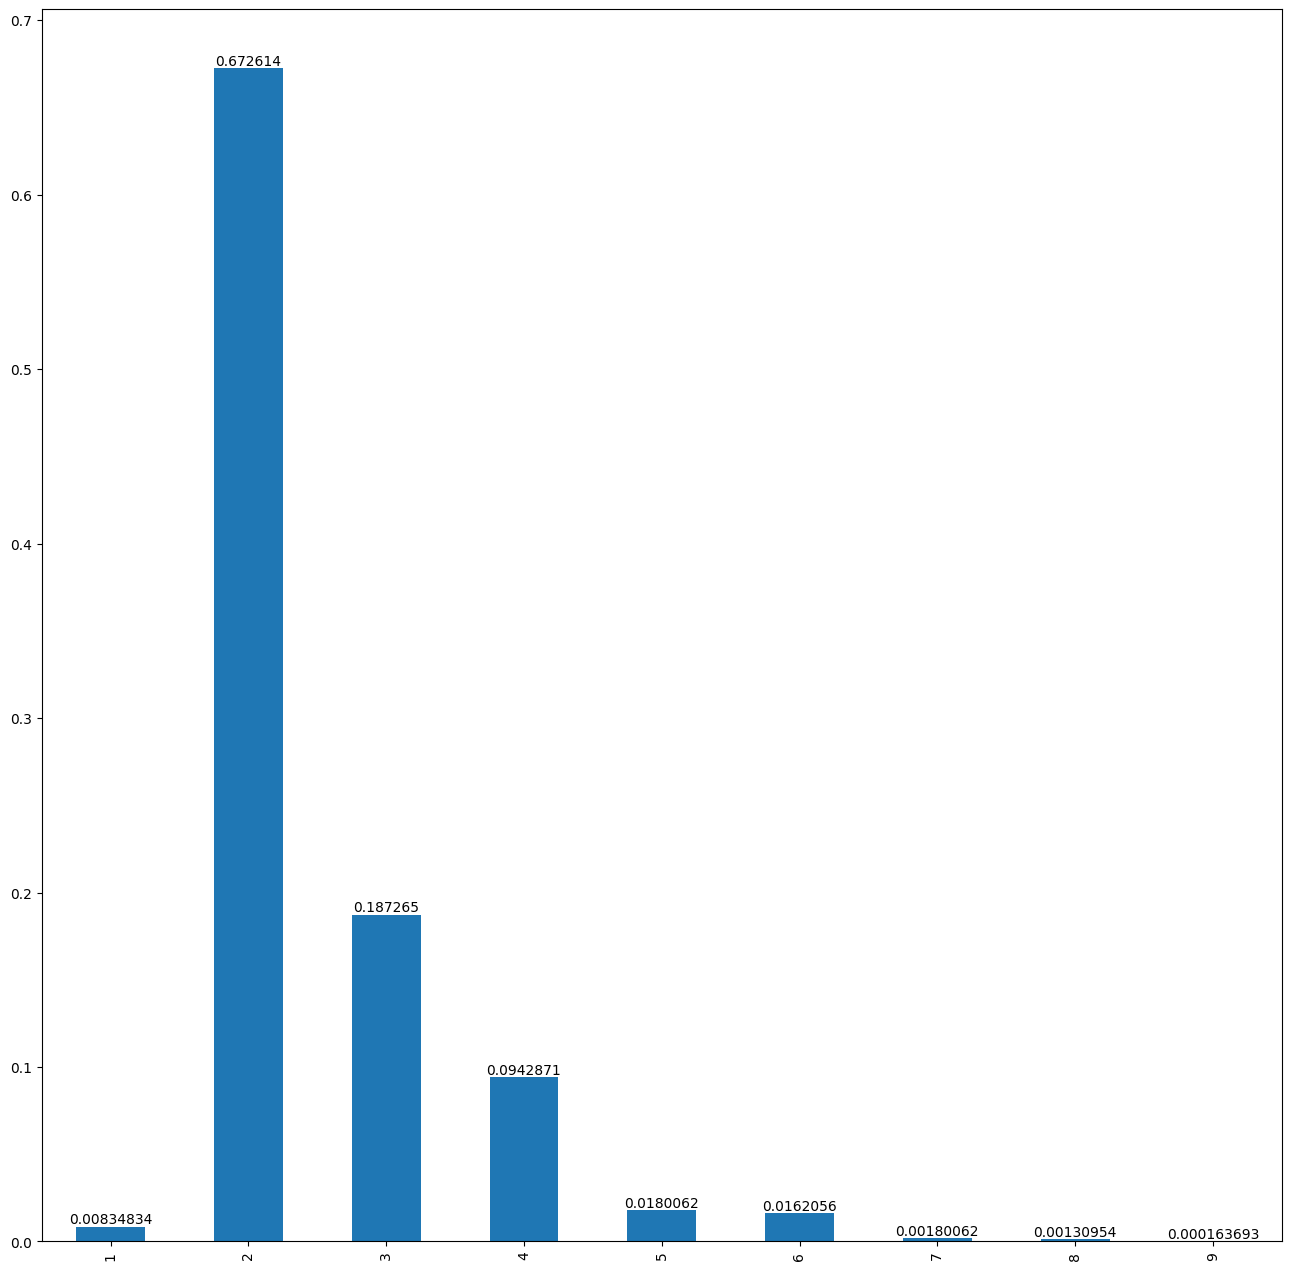

In [18]:
ax = korean_company_names[korean_company_names.isin(homonyms['표층형'])].str.len().value_counts(
    normalize=True, sort=False).sort_index().plot(kind='bar', figsize=(16, 16))
res = ax.bar_label(ax.containers[0])

### Distribution of the `품사` (Part-Of-Speech, POS)

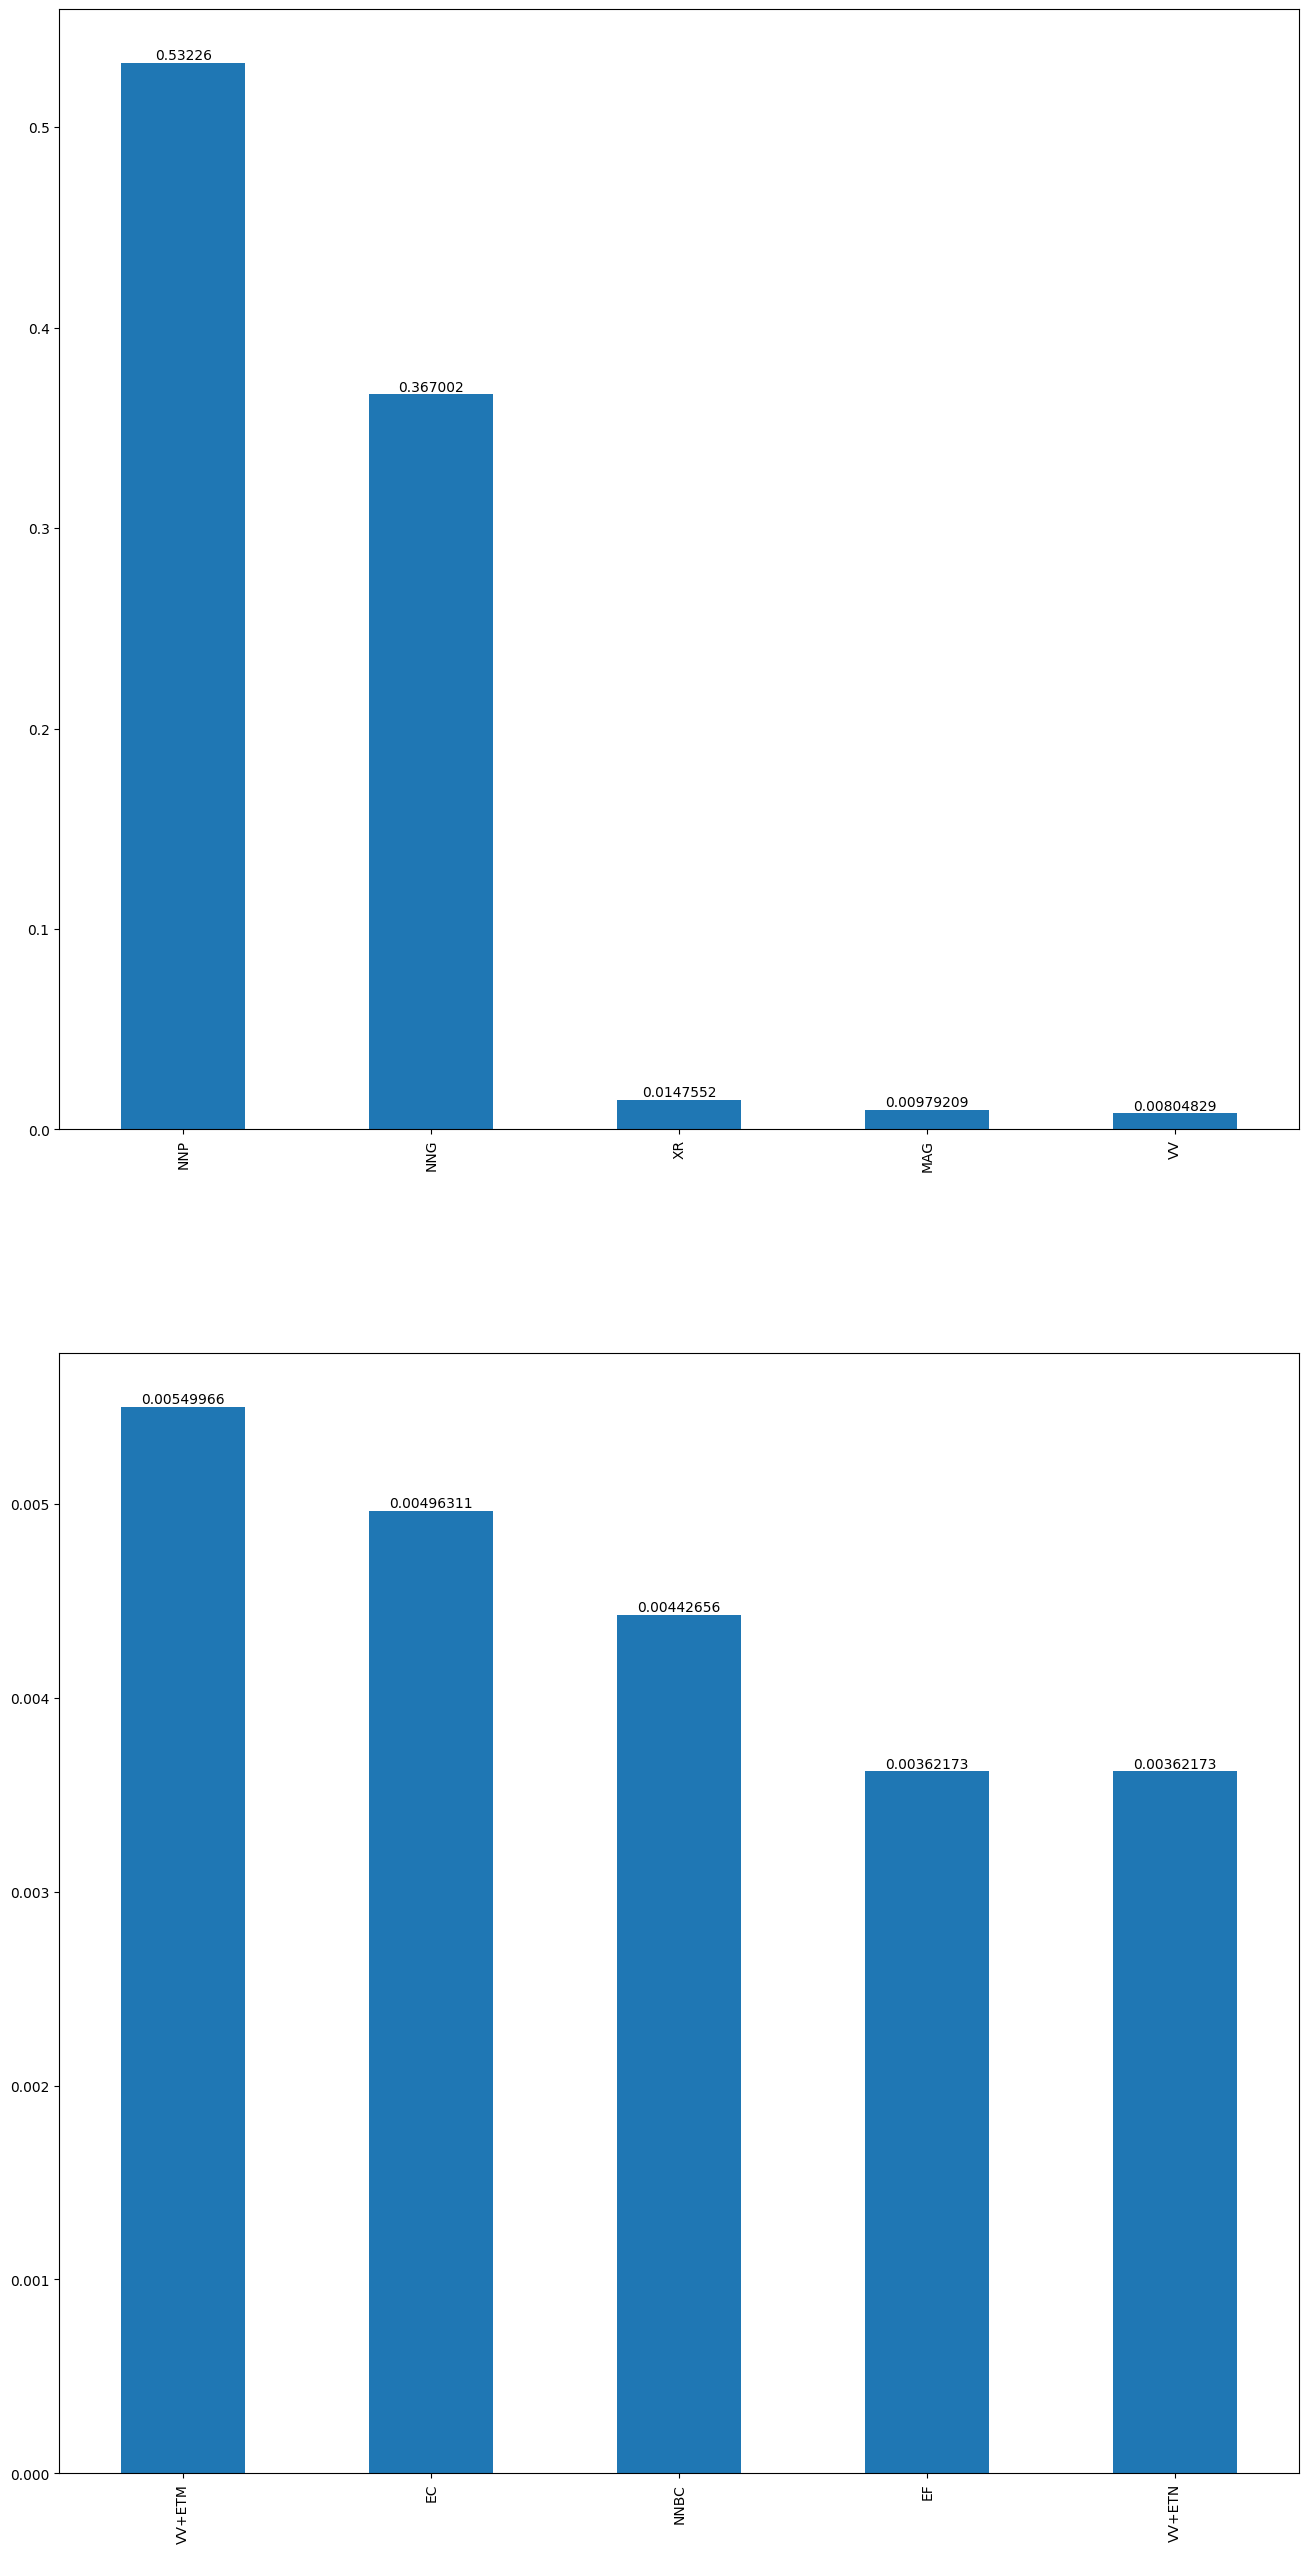

In [19]:
barchart_group_size = 5
num_images = 2 # math.ceil(homonyms['품사'].unique().shape[0]/barchart_group_size)

fig, axs = plt.subplots(num_images)

for idx in range(num_images):
    head_idx = barchart_group_size * idx
    tail_idx = head_idx + barchart_group_size
    ax = homonyms['품사'].value_counts(normalize=True)[head_idx:tail_idx].plot(figsize=(16, 32), kind='bar', ax=axs[idx])
    res = ax.bar_label(ax.containers[0])

### Distribution of the `소스` (source `.csv` in which the vocabulary exists)

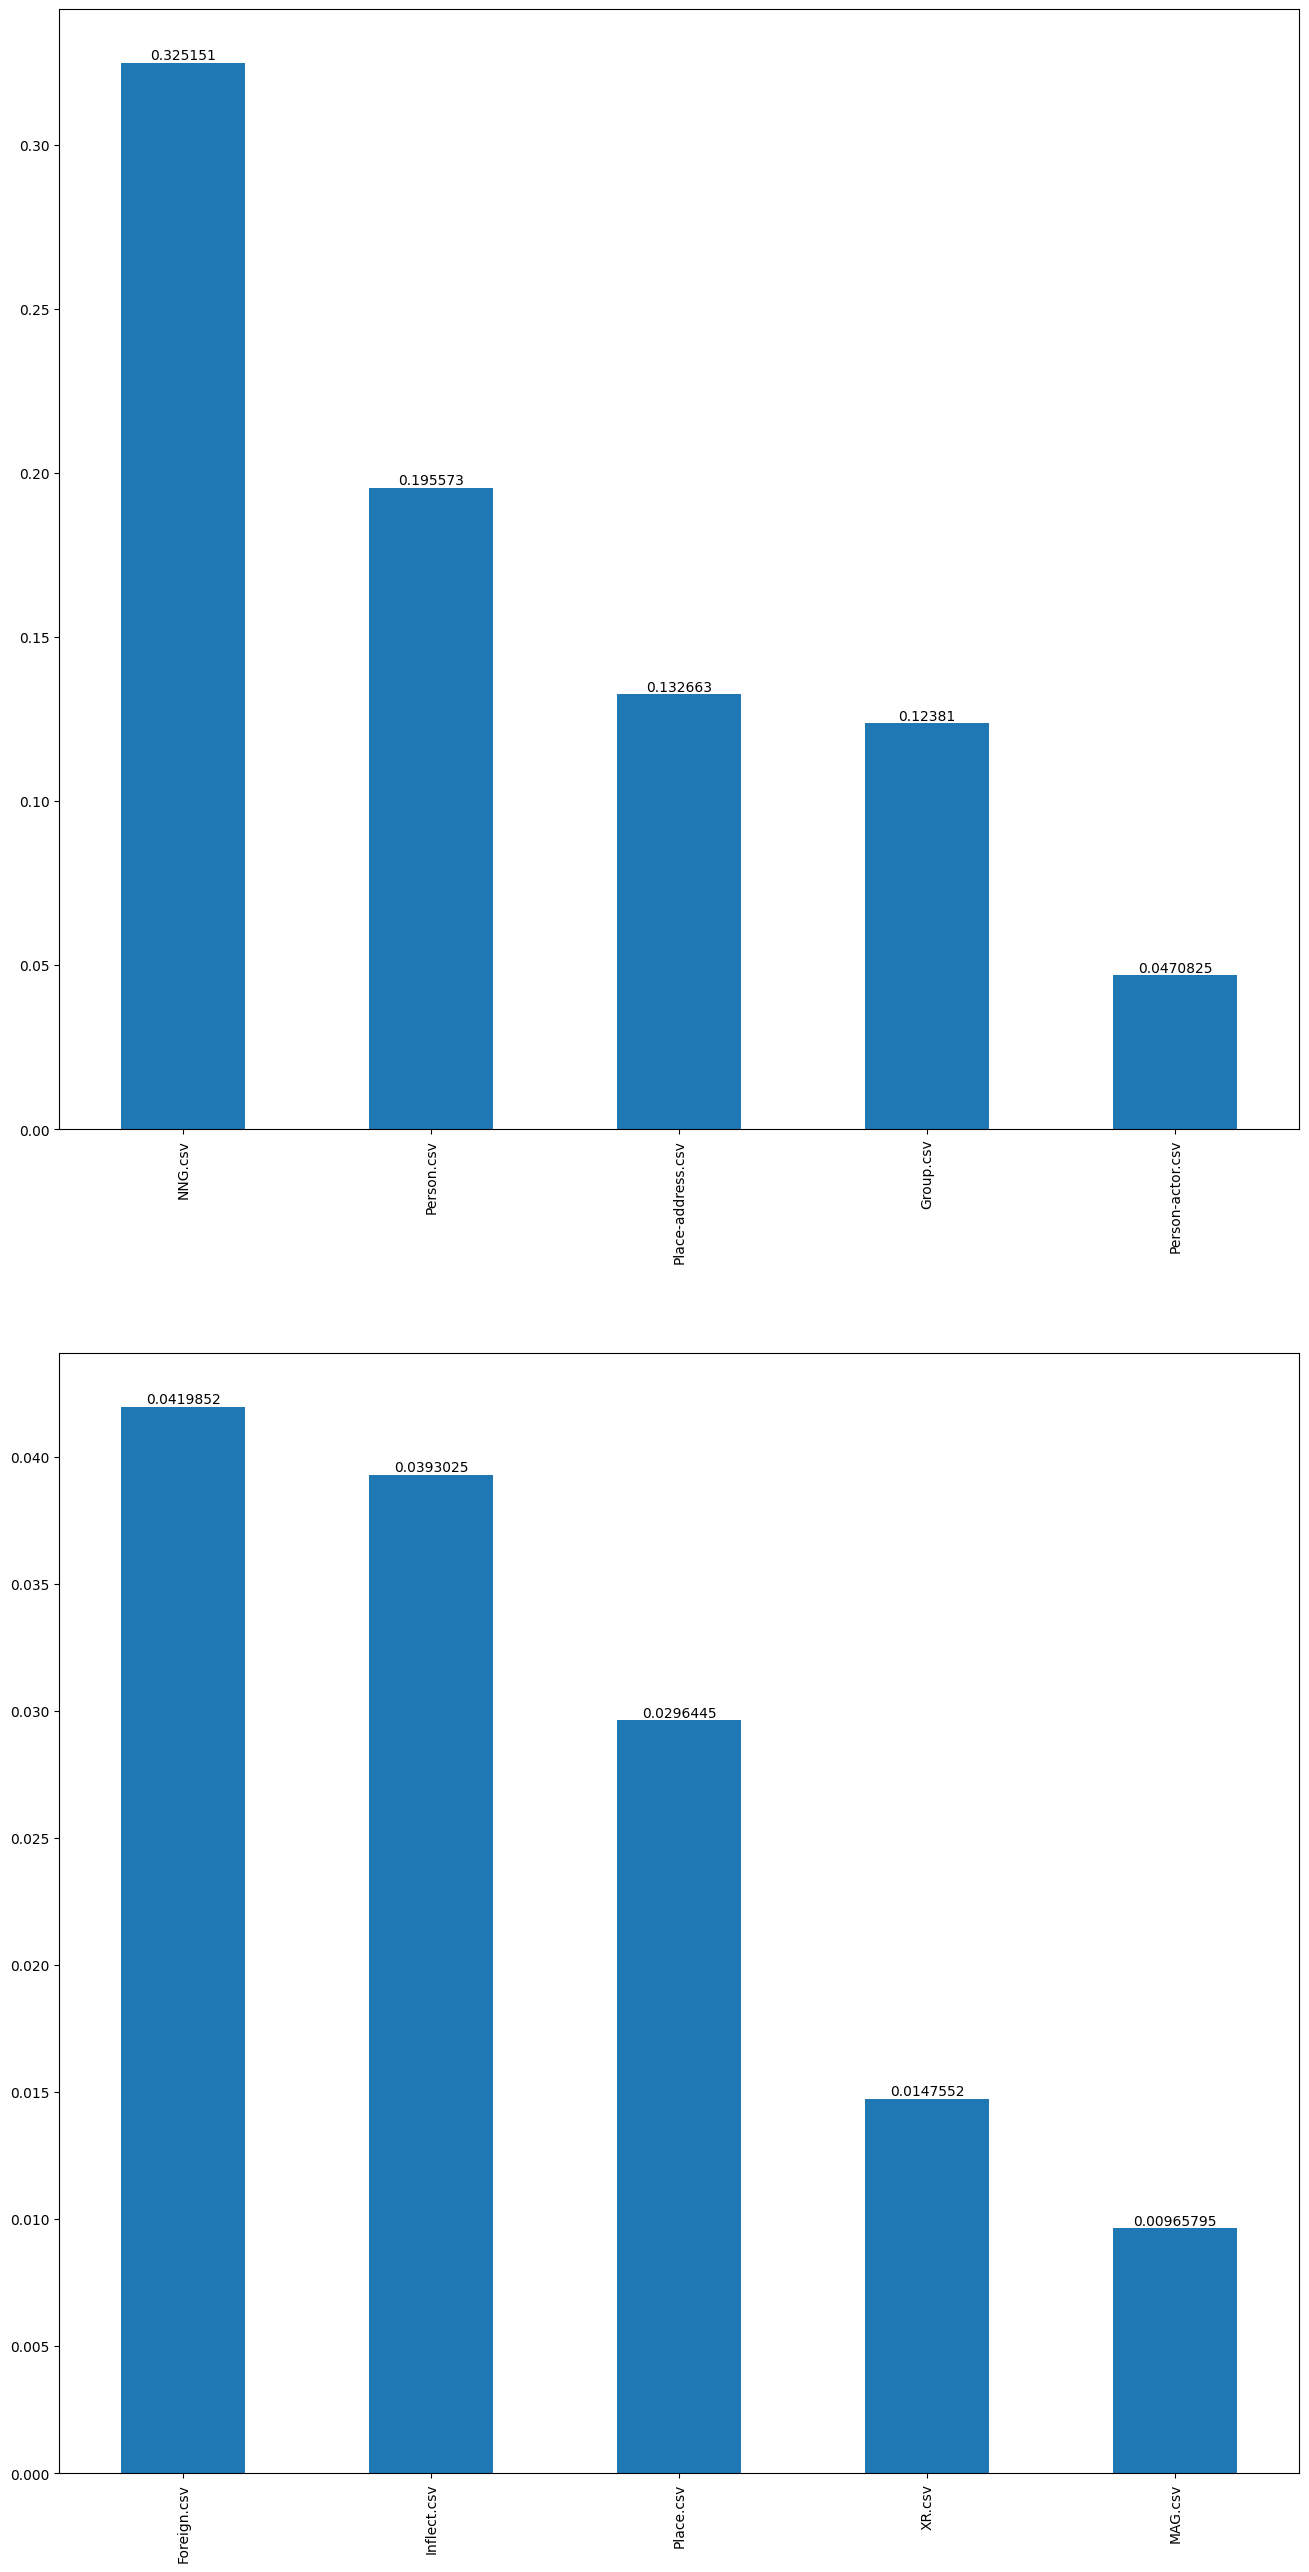

In [20]:
barchart_group_size = 5
num_images = 2 # math.ceil(homonyms['소스'].unique().shape[0]/barchart_group_size)

fig, axs = plt.subplots(num_images)

for idx in range(num_images):
    head_idx = barchart_group_size * idx
    tail_idx = head_idx + barchart_group_size
    ax = homonyms['소스'].value_counts(normalize=True)[head_idx:tail_idx].plot(figsize=(16, 32), kind='bar', ax=axs[idx])
    res = ax.bar_label(ax.containers[0])